In [2]:
height = 96
width = 1408
max_text_length = 0
batch_size = 32
learning_rate = 0.0001
train_epochs = 1000
train_workers = 20
vocab=""

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers as layers

In [5]:
import os
from tqdm import tqdm
import csv



# Paths for datasets
sentences_txt_path = "./metadata/sentences.txt"
sentences_folder_path = "./dataset"

# Load and process dataset
dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    max_len = max(max_len, len(label))


max_text_length = max_len



csv_file_path = "data.csv"

# Write the data to the CSV file with labeled columns
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row with labeled columns
    writer.writerow(["path", "label"])
    
    # Write the data
    writer.writerows(dataset)

print("CSV file has been created successfully.")

100%|██████████| 16777/16777 [00:08<00:00, 2011.70it/s]

CSV file has been created successfully.


In [6]:
data = pd.read_csv("./data.csv")

In [7]:
data.head()

,path,label
0,./dataset\a01-000u-s00-00.png,A MOVE to stop Mr. Gaitskell from
1,./dataset\a01-000u-s00-01.png,nominating any more Labour life Peers
2,./dataset\a01-000u-s00-02.png,is to be made at a meeting of Labour
3,./dataset\a01-000u-s01-01.png,put down a resolution on the subject
4,./dataset\a01-000u-s01-03.png,P for Manchester Exchange .


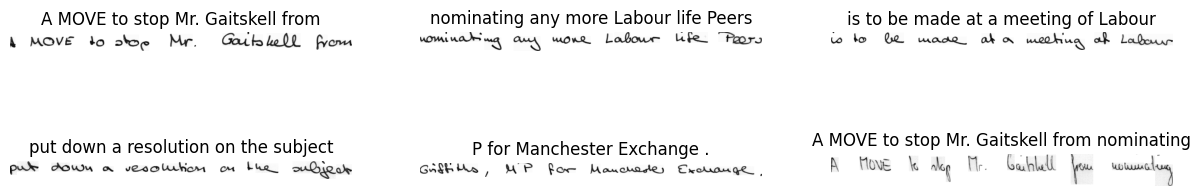

In [8]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(data.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


In [9]:
print("Number of NaNs in train set      : ", data['label'].isnull().sum())

Number of NaNs in train set      :  3


In [10]:
data.dropna(axis=0, inplace=True)

In [11]:
data['label'] = data['label'].str.upper()

In [12]:
data.reset_index(inplace = True, drop=True) 

In [13]:
train_y_labels_max=0
train_y_labels_sum=0
train_y_labels_count_freq={}
for i in range(len(data)):
    freq=len(data.loc[i,'label'])
    if freq in train_y_labels_count_freq:
        train_y_labels_count_freq[freq]=train_y_labels_count_freq[freq]+1
    else:
        train_y_labels_count_freq[freq]=1
    if freq>train_y_labels_max:
        train_y_labels_max=freq
    train_y_labels_sum = train_y_labels_sum+freq

print('max len:', train_y_labels_max)
print('avg len:', train_y_labels_sum/len(data))

max len: 93
avg len: 34.388991477272725


<BarContainer object of 79 artists>

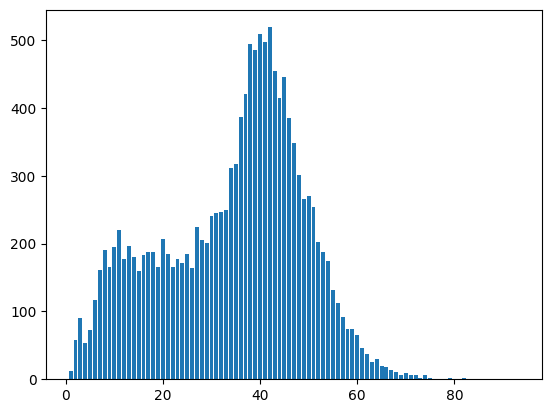

In [14]:
plt.bar(list(train_y_labels_count_freq.keys()),list(train_y_labels_count_freq.values()))

In [15]:
def augment_image1(image):
    # Random Gaussian Blur
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)  # Horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)  # Vertical flip
        
    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)  
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)  
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # Random Brightness Adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.8, 1.1)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random Contrast Adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.3, 1.3)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # Random Saturation Adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.3, 1.3)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # Extract the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]
        
    rows, cols = image.shape
    shear_angle_x = np.random.uniform(-0.8, 0.8)  # Range for x-axis shear (-0.2 to 0.2 radians)
    shear_matrix_x = np.float32([[1, shear_angle_x, 0], [0, 1, 0]])
    sheared_image = cv2.warpAffine(image.copy(), shear_matrix_x, (cols, rows))

    return sheared_image

In [16]:
def augment_image2(image):
    # Random Gaussian Blur
#     if np.random.rand() < 0.5:
#         image = cv2.flip(image, 0)  # Horizontal flip
#     if np.random.rand() < 0.5:
#         image = cv2.flip(image, 1)  # Vertical flip
        
    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)  
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)  
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # Random Brightness Adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.8, 1.1)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random Contrast Adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.3, 1.3)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # Random Saturation Adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.3, 1.3)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # Extract the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]
        
    rows, cols = image.shape
    shear_angle_x = np.random.uniform(-0.8, 0.8)  # Range for x-axis shear (-0.2 to 0.2 radians)
    shear_matrix_x = np.float32([[1, shear_angle_x, 0], [0, 1, 0]])
    sheared_image = cv2.warpAffine(image.copy(), shear_matrix_x, (cols, rows))

    return sheared_image

In [17]:
def resize_or_pad_image(image, target_height=64, target_width=512):
    image = cv2.resize(image, (target_width, target_height))
    return image

def preprocess(img):
    (h, w) = img.shape    
    final_image = resize_or_pad_image(img)
    return cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)

In [18]:
def preprocess1(img):
    (h, w) = img.shape    
    final_image = resize_or_pad_image(img)
    return augment_image2(final_image)

In [19]:
import cv2

# Load the image
flag=0
for i in range(1,100):
    image = cv2.imread(data.loc[i,'path'])
    image = resize_or_pad_image(image)
    image_shape = image.shape

    print("Shape of the image:", image_shape)

Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of t

In [20]:
img_paths = ['./dataset/a01-000u-s00-00.png',
             './dataset/a01-000u-s00-01.png',
             './dataset/a01-000u-s00-02.png']

1
1
1


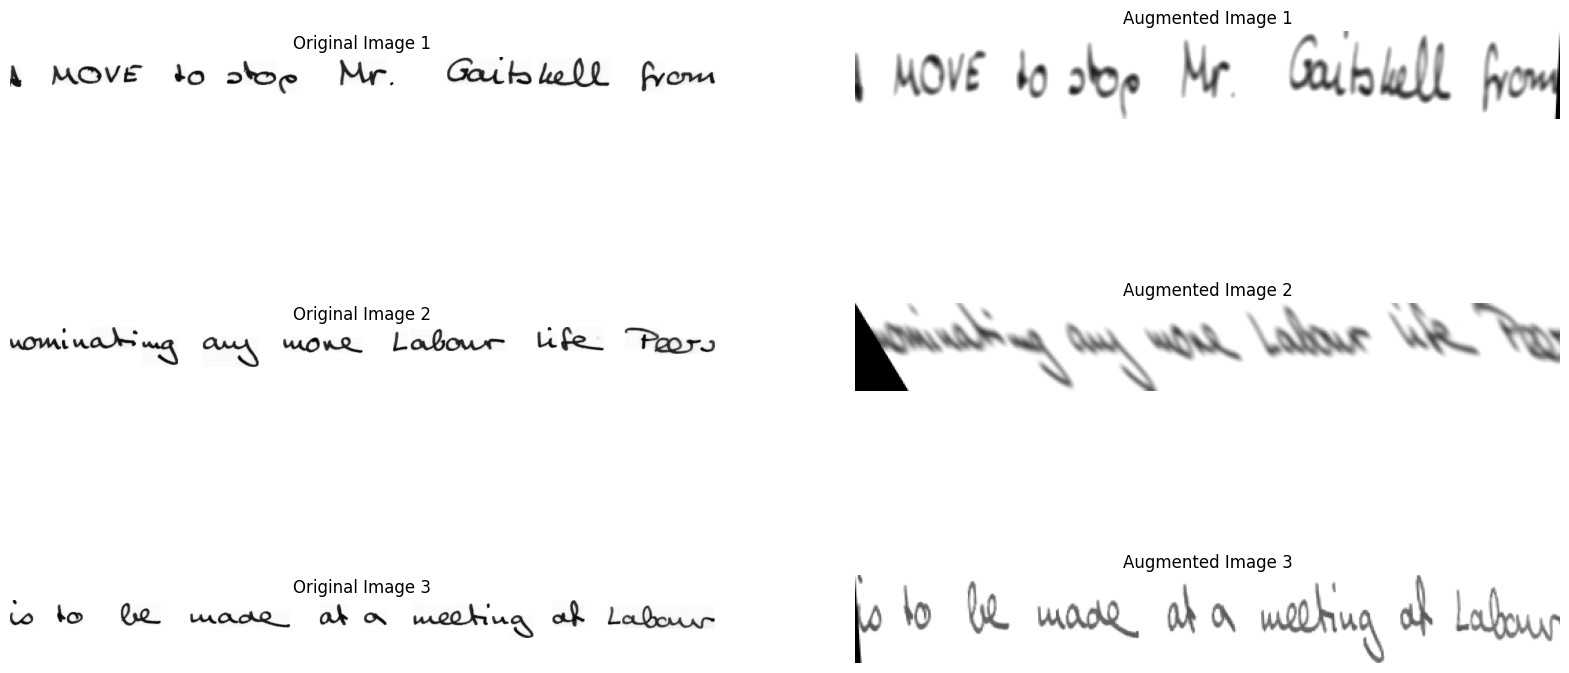

In [21]:
plt.figure(figsize=(20, 10))

for i in range(3):
    img_path = img_paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    aug_img = preprocess1(img)
    print(1)
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

In [22]:
len(data)

14080

In [23]:
train_size = 12080
valid_size = 1000
test_size = 1000

In [24]:
img_aug_cnt=0

In [25]:
train_x = []

for i in range(train_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    
    t=image
    if random.randint(0, 10) in [1,2,3,4,5]:
        t= augment_image2(t)
        img_aug_cnt=img_aug_cnt+1

    t = preprocess(t)
    t = t/255.
    train_x.append(t)

In [26]:
valid_x = []

for i in range(train_size,train_size+valid_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [27]:
test_x = []

for i in range(train_size+valid_size,train_size+test_size+valid_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [28]:
print('train:',len(train_x),'valid:',len(valid_x),'test:',len(test_x))

train: 12080 valid: 1000 test: 1000


In [29]:
np.asarray(train_x).shape

(12080, 512, 64)

In [30]:
train_x = np.array(train_x).reshape(-1, 512, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 512, 64, 1)
test_x = np.array(test_x).reshape(-1, 512, 64, 1)

In [31]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-,!?.' "
max_str_len = 95 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        ind=alphabets.find(ch)
        if ind != -1:
            label_num.append(ind)
        else:
            label_num.append(0)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [32]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [33]:
train_y = np.ones([train_size,max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(data.loc[i, 'label'])
    train_y[i, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])  

In [34]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(train_size,train_size+valid_size):
    valid_label_len[i-train_size] = len(data.loc[i, 'label'])
    valid_y[i-train_size, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])   

In [35]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(train_size+valid_size,train_size+valid_size+test_size):
    test_label_len[i-(train_size+valid_size)] = len(data.loc[i, 'label'])
    test_y[i-(train_size+valid_size), 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label']) 

In [36]:
print('True label : ',data.loc[100, 'label'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  THE TALKS FALL THROUGH . 
train_y :  [19.  7.  4. 32. 19.  0. 11. 10. 18. 32.  5.  0. 11. 11. 32. 19.  7. 17.
 14. 20.  6.  7. 32. 30. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.] 
train_label_len :  [24.] 
train_input_len :  [126.]


In [37]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 pre-trained on ImageNet, excluding the top layers
mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))

# Freeze the pre-trained layers to prevent them from updating during training
mobilenet_v2.trainable = False

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16188\3318005239.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))


In [38]:
from tensorflow.keras.layers import Concatenate,Flatten

In [39]:
# crnn approach
input_data = Input(shape=(512, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.5)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)


inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# CNN to RNN
inner = Reshape(target_shape=((128, 1024)), name='reshape')(inner)
inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 512, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 512, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 256, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 256, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 128, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 128, 16, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 128, 16, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 16, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 128, 512)       │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 128, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128, 34)        │        17,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 128, 34)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,186 (10.50 MB)

 Trainable params: 2,752,738 (10.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [40]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [41]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [42]:
model_final.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 64,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 512, 64,   │        320 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 64,   │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 64,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max1 (MaxPooling2D) │ (None, 256, 32,   │          0 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 256, 32,   │     18,496 │ max1[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32,   │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max2 (MaxPooling2D) │ (None, 128, 16,   │          0 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 16,   │          0 │ max2[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 128, 16,   │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv2D)      │ (None, 128, 16,   │    147,584 │ conv3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 16,   │        512 │ conv4[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 16,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max3 (MaxPooling2D) │ (None, 128, 8,    │          0 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 8,    │          0 │ max3[0][0]        │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 1024) │          0 │ dropout_1[0][0] 

 Total params: 2,753,186 (10.50 MB)

 Trainable params: 2,752,738 (10.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
optimizer = Adam(learning_rate=0.001)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=40, batch_size=64,verbose=1)
# ,callbacks=[early_stopping]

Epoch 1/40

189/189 ━━━━━━━━━━━━━━━━━━━━ 823s 4s/step - loss: 111.8319 - val_loss: 78.2180
Epoch 2/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 777s 4s/step - loss: 73.5911 - val_loss: 92.8124
Epoch 3/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - loss: 51.5950 - val_loss: 37.9893
Epoch 4/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - loss: 40.9176 - val_loss: 25.5268
Epoch 5/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 763s 4s/step - loss: 34.0821 - val_loss: 21.8392
Epoch 6/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 758s 4s/step - loss: 29.3888 - val_loss: 20.2849
Epoch 7/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 665s 4s/step - loss: 26.2185 - val_loss: 18.0268
Epoch 8/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 633s 3s/step - loss: 23.6947 - val_loss: 16.4212
Epoch 9/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 638s 3s/step - loss: 21.5870 - val_loss: 15.8988
Epoch 10/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 630s 3s/step - loss: 20.0510 - val_loss: 14.8892
Epoch 11/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 631s 3s/step - loss: 18.2490 - val_loss: 14.2807
Epoch 12/40
189/1

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


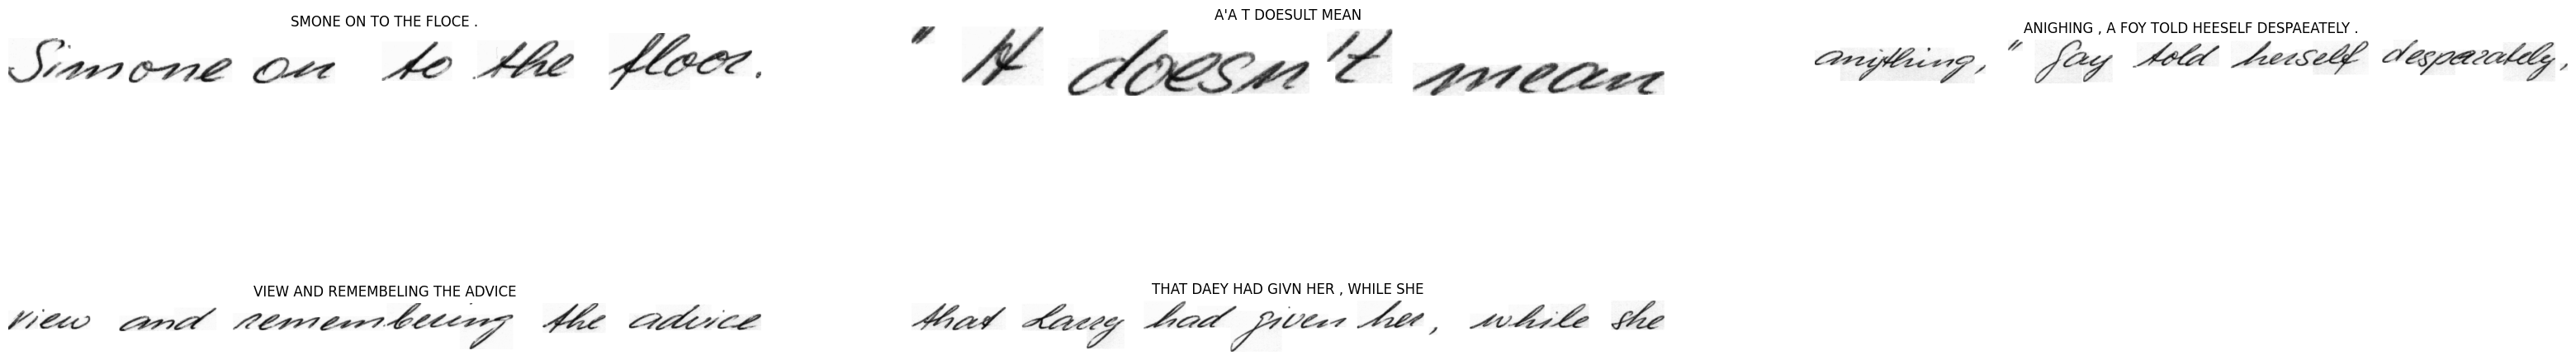

In [44]:
plt.figure(figsize=(40, 25))
for i in range(0,5):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i+train_size+valid_size, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 512, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

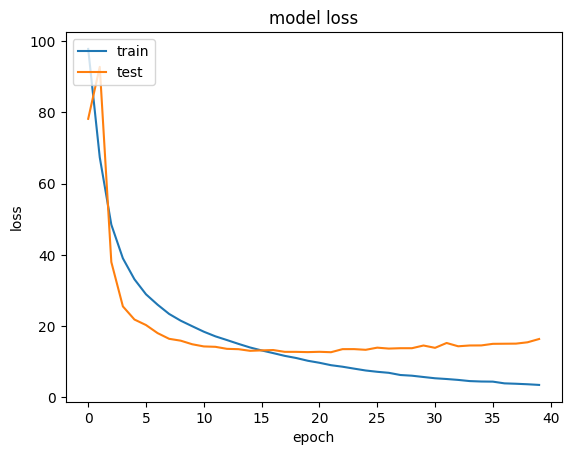

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
model.save_weights('crnnw2d4.weights.h5')

In [47]:
preds = model.predict(test_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step


In [48]:
y_true = data.loc[train_size+valid_size:train_size+valid_size+test_size, 'label']


def calculate_accuracy(y_true, y_pred):
    total_words = 0
    correct_words = 0
    total_char = 0
    correct_char = 0

    for true_sentence, pred_sentence in zip(y_true, y_pred):
        true_words = true_sentence.split()
        pred_words = pred_sentence.split()
        

        total_words += len(true_words)

        # Calculate word accuracy
        for true_word, pred_word in zip(true_words, pred_words):
            if true_word == pred_word:
                correct_words += 1

            total_char += len(true_word)
    
            for j in range(min(len(true_word), len(pred_word))):
                if true_word[j] == pred_word[j]:
                    correct_char += 1

    word_accuracy = correct_words / total_words if total_words > 0 else 0
    character_accuracy = correct_char/ total_char if total_char> 0 else 0

    return word_accuracy, character_accuracy


word_accuracy, character_accuracy = calculate_accuracy(y_true, prediction)
print("Word Accuracy:", word_accuracy)
print("Character Accuracy:", character_accuracy)

Word Accuracy: 0.5972369819341127
Character Accuracy: 0.7332369129404203
